In [2]:
import pandas as pd
from pandas import MultiIndex, Int16Dtype

import numpy as np
from sklearn.feature_extraction import DictVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 500)

In [3]:
filepath = '../datas/'
filename =  'student_data.csv'
df_student = pd.read_csv(filepath + filename)

In [4]:
df_student

,StudentID,FirstName,FamilyName,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade
0,0,Rafael,Morais,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,6
1,1,Lara,Braga,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,6
2,2,Gonçalo,Azevedo,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,10
3,3,Lara,Perna,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15
4,4,João,Pires,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,390,Alice,Barcellos,MS,M,20,U,LE3,A,2,2,services,services,course,other,1,2,2,no,yes,yes,no,yes,yes,no,no,5,5,4,4,5,4,11,9
353,391,Rodrigo,Quintal,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,3,16
354,392,Carolina,Hiza,MS,M,21,R,GT3,T,1,1,other,other,course,other,1,1,3,no,no,no,no,no,yes,no,no,5,5,3,3,3,3,3,7
355,393,Benedita,Amaral,MS,M,18,R,LE3,T,3,2,services,other,course,mother,3,1,0,no,no,no,no,no,yes,yes,no,4,4,1,3,4,5,0,10


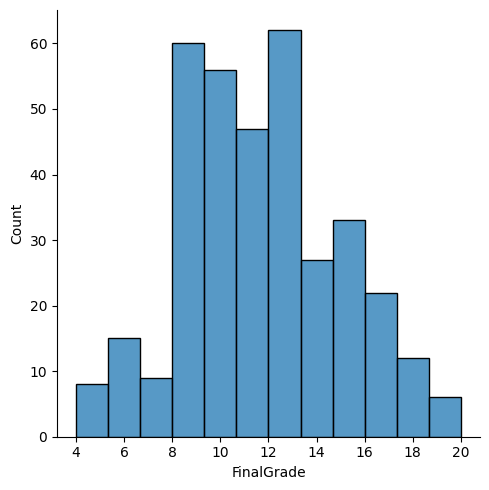

In [5]:
sns.displot(df_student['FinalGrade'])

### Missing values

In [6]:
df_isna = df_student.isna().sum()
df_isna.sum()

0

In [7]:
target = ['FinalGrade']
columns_numerical = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
columns_boolean = ['schoolsup', 'paid', 'famsup', 'activities', 'nursery', 'higher', 'internet', 'romantic']
columns_categorical = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian']

len(target) + len(columns_numerical) + len(columns_categorical) + len(columns_boolean)

31

In [8]:
liste_col = list(df_student.columns)
liste_col.remove('StudentID')

In [9]:
df_student.describe()

,StudentID,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,193.176471,16.655462,2.795518,2.546218,1.431373,2.042017,0.271709,3.955182,3.246499,3.098039,1.495798,2.330532,3.549020,6.316527,11.523810
std,115.771252,1.268262,1.093999,1.084217,0.686075,0.831895,0.671750,0.885721,1.011601,1.090779,0.919886,1.294974,1.402638,8.187623,3.227797
min,0.000000,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000
25%,89.000000,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,2.000000,9.000000
50%,196.000000,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000
75%,292.000000,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,14.000000
max,394.000000,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,20.000000


### Boolean columns

In [10]:
def convert_bool_in_number(df, column_name):
    df[column_name] = pd.Series(np.where(df[column_name].values == 'yes', 1, 0),
          df.index)
        
    return df

In [11]:
df_student_2 = df_student.copy()

for column in columns_boolean:
    df_student_2 = convert_bool_in_number(df_student_2, column)

### Categorical columns

In [12]:
def encode_and_concat(df, categorical_column):

    dummies = pd.get_dummies(df[categorical_column], prefix= str(categorical_column))
    df_concat = pd.concat([df, dummies], axis=1)
    df_concat = df_concat.drop(categorical_column, axis = 1)

    return(df_concat)

In [13]:
df_concat = df_student_2.copy()

for column in columns_categorical:
    df_concat = encode_and_concat(df_concat, column)

In [14]:
df_concat.describe()

,StudentID,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.00000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,193.176471,16.655462,2.795518,2.546218,1.431373,2.042017,0.271709,0.140056,0.613445,0.484594,0.504202,0.801120,0.960784,0.837535,0.313725,3.955182,3.246499,3.098039,1.495798,2.330532,3.549020,6.316527,11.523810,0.882353,0.117647,0.518207,0.481793,0.218487,0.781513,0.700280,0.299720,0.109244,0.890756,0.140056,0.089636,0.355742,0.263305,0.151261,0.047619,0.050420,0.54902,0.280112,0.072829,0.352941,0.271709,0.098039,0.277311,0.229692,0.694678,0.075630
std,115.771252,1.268262,1.093999,1.084217,0.686075,0.831895,0.671750,0.347532,0.487644,0.500464,0.500684,0.399717,0.194380,0.369395,0.464657,0.885721,1.011601,1.090779,0.919886,1.294974,1.402638,8.187623,3.227797,0.322642,0.322642,0.500370,0.500370,0.413800,0.413800,0.458778,0.458778,0.312383,0.312383,0.347532,0.286060,0.479410,0.441045,0.358805,0.213258,0.219117,0.49829,0.449684,0.260221,0.478555,0.445465,0.297785,0.448300,0.421225,0.461190,0.264777
min,0.000000,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,89.000000,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,2.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,196.000000,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,292.000000,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,14.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,394.000000,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.0000

In [15]:
df_preprocessed = df_concat.copy()

very_good_marks = (df_preprocessed['FinalGrade'] >= 15) & (df_preprocessed['FinalGrade'] <= 20)
good_marks = (df_preprocessed['FinalGrade'] >= 10) & (df_preprocessed['FinalGrade'] <= 15)
bad_marks = (df_preprocessed['FinalGrade'] >= 5) & (df_preprocessed['FinalGrade'] <= 10)
very_bad_marks = (df_preprocessed['FinalGrade'] >= 0) & (df_preprocessed['FinalGrade'] <= 5)

In [16]:
df_preprocessed[very_good_marks].describe()

,StudentID,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,172.986301,16.328767,3.219178,2.780822,1.315068,2.178082,0.041096,0.027397,0.575342,0.438356,0.534247,0.835616,1.0,0.931507,0.246575,4.013699,3.287671,2.863014,1.205479,1.904110,3.397260,3.698630,16.219178,0.917808,0.082192,0.438356,0.561644,0.136986,0.863014,0.671233,0.328767,0.123288,0.876712,0.082192,0.150685,0.219178,0.356164,0.191781,0.054795,0.054795,0.452055,0.273973,0.164384,0.342466,0.260274,0.095890,0.301370,0.219178,0.739726,0.041096
std,122.688686,1.213979,1.017166,1.070392,0.549664,0.918067,0.260254,0.164368,0.497712,0.499619,0.502278,0.373188,0.0,0.254338,0.434000,0.935313,1.073409,1.084167,0.498857,1.144606,1.578851,4.906586,1.416633,0.276557,0.276557,0.499619,0.499619,0.346212,0.346212,0.473016,0.473016,0.331042,0.331042,0.276557,0.360217,0.416552,0.482179,0.396426,0.229154,0.229154,0.501140,0.449082,0.373188,0.477818,0.441821,0.296479,0.462028,0.416552,0.441821,0.199886
min,3.000000,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,15.000000,3.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,158.000000,16.000000,4.000000,3.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.0,1.000000,0.000000,4.000000,3.000000,3.000000,1.000000,1.000000,4.000000,2.000000,16.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,291.000000,17.000000,4.000000,4.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,5.000000,4.000000,3.000000,1.000000,3.000000,5.000000,5.000000,17.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,391.000000,20.000000,4.000000,4.000000,3.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,5.000000,5.000000,5.000000,3.000000,5.000000,5.000000,24.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [17]:
df_preprocessed[bad_marks + very_bad_marks].describe()

,StudentID,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,200.290541,16.858108,2.621622,2.331081,1.533784,1.939189,0.506757,0.216216,0.635135,0.493243,0.493243,0.824324,0.932432,0.797297,0.290541,3.986486,3.263514,3.310811,1.601351,2.608108,3.560811,7.777027,8.513514,0.844595,0.155405,0.554054,0.445946,0.270270,0.729730,0.709459,0.290541,0.094595,0.905405,0.202703,0.054054,0.371622,0.209459,0.162162,0.040541,0.054054,0.581081,0.283784,0.040541,0.364865,0.277027,0.101351,0.256757,0.222973,0.682432,0.094595
std,115.573180,1.314545,1.109056,1.058741,0.759659,0.766886,0.914707,0.413061,0.483027,0.501652,0.501652,0.381836,0.251855,0.403378,0.455553,0.773599,1.005843,1.099483,0.945738,1.348394,1.331085,9.627639,1.567035,0.363521,0.363521,0.498757,0.498757,0.445607,0.445607,0.455553,0.455553,0.293648,0.293648,0.403378,0.226892,0.484879,0.408305,0.369851,0.197893,0.226892,0.495057,0.452364,0.197893,0.483027,0.449050,0.302818,0.438327,0.417654,0.467111,0.293648
min,0.000000,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,92.750000,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,3.000000,1.000000,1.000000,3.000000,2.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,202.500000,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,3.000000,1.000000,3.000000,4.000000,5.000000,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,281.500000,18.000000,4.000000,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,2.000000,4.000000,5.000000,10.000000,10.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,394.000000,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,7

In [18]:
df_preprocessed[good_marks].describe()

,StudentID,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.00000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,195.271111,16.560000,2.751111,2.568889,1.453333,2.057778,0.182222,0.120000,0.591111,0.520000,0.511111,0.773333,0.968889,0.835556,0.315556,3.955556,3.200000,2.968889,1.475556,2.328889,3.524444,5.351111,12.111111,0.884444,0.115556,0.520000,0.480000,0.213333,0.786667,0.706667,0.293333,0.106667,0.893333,0.155556,0.097778,0.36000,0.253333,0.133333,0.044444,0.044444,0.582222,0.271111,0.057778,0.333333,0.275556,0.102222,0.288889,0.244444,0.693333,0.062222
std,116.574441,1.182914,1.098014,1.079811,0.712641,0.835188,0.532552,0.325686,0.492725,0.500714,0.500991,0.419609,0.174005,0.371505,0.465773,0.895314,0.991031,1.053867,0.926099,1.256523,1.420695,6.568072,1.773090,0.320404,0.320404,0.500714,0.500714,0.410575,0.410575,0.456305,0.456305,0.309377,0.309377,0.363242,0.297676,0.48107,0.435890,0.340693,0.206540,0.206540,0.494293,0.445524,0.233843,0.472456,0.447790,0.303616,0.454257,0.430716,0.462138,0.242097
min,2.000000,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,87.000000,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,2.000000,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,199.000000,16.000000,3.000000,3.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,12.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,298.000000,17.000000,4.000000,4.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,14.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,393.000000,20.000000,4.000000,4.000000,4.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,54.00

In [19]:
df_preprocessed[bad_marks].describe()

,StudentID,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000
mean,200.183673,16.857143,2.612245,2.326531,1.537415,1.938776,0.496599,0.217687,0.639456,0.489796,0.496599,0.823129,0.931973,0.795918,0.285714,3.993197,3.258503,3.299320,1.598639,2.598639,3.578231,7.680272,8.544218,0.843537,0.156463,0.551020,0.448980,0.272109,0.727891,0.707483,0.292517,0.095238,0.904762,0.204082,0.054422,0.367347,0.210884,0.163265,0.040816,0.054422,0.578231,0.285714,0.040816,0.367347,0.278912,0.102041,0.251701,0.224490,0.680272,0.095238
std,115.960965,1.318987,1.106946,1.060907,0.760966,0.769491,0.909419,0.414084,0.481800,0.501605,0.501698,0.382864,0.252653,0.404407,0.453298,0.771909,1.007427,1.094288,0.948393,1.348057,1.318598,9.588082,1.527068,0.364535,0.364535,0.499091,0.499091,0.446567,0.446567,0.456474,0.456474,0.294547,0.294547,0.404407,0.227624,0.483730,0.409331,0.370871,0.198541,0.227624,0.495530,0.453298,0.198541,0.483730,0.449997,0.303737,0.435474,0.418672,0.467965,0.294547
min,0.000000,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,92.500000,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,3.000000,1.000000,1.000000,3.000000,2.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,202.000000,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,3.000000,1.000000,3.000000,4.000000,5.000000,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,282.000000,18.000000,4.000000,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,2.000000,4.000000,5.000000,10.000000,10.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.500000,0.000000,1.000000,0.000000
max,394.000000,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,7

In [20]:
df_preprocessed[very_bad_marks].describe()

,StudentID,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
count,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.000000,8.0,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.00000,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.0,8.0,8.000000,8.0,8.000000,8.00000,8.0,8.0,8.0,8.000000,8.000000,8.0,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,8.0
mean,186.250000,16.750000,2.875000,2.62500,1.125000,1.500000,1.125000,0.25000,0.625000,0.375000,0.375000,0.875000,1.0,0.875000,0.375000,3.62500,4.125000,4.125000,2.250000,3.50000,3.375000,12.750000,4.875000,0.75000,0.25000,0.500000,0.500000,0.500000,0.500000,0.875000,0.125000,0.0,1.0,0.125000,0.0,0.625000,0.25000,0.0,0.0,0.0,0.625000,0.375000,0.0,0.500000,0.125000,0.125000,0.25000,0.125000,0.875000,0.0
std,140.905997,1.035098,1.246423,1.06066,0.353553,0.534522,1.125992,0.46291,0.517549,0.517549,0.517549,0.353553,0.0,0.353553,0.517549,1.06066,0.834523,0.991031,1.488048,0.92582,1.685018,5.849298,0.353553,0.46291,0.46291,0.534522,0.534522,0.534522,0.534522,0.353553,0.353553,0.0,0.0,0.353553,0.0,0.517549,0.46291,0.0,0.0,0.0,0.517549,0.517549,0.0,0.534522,0.353553,0.353553,0.46291,0.353553,0.353553,0.0
min,18.000000,15.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,2.00000,3.000000,3.000000,1.000000,2.00000,1.000000,2.000000,4.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0
25%,77.250000,16.000000,2.500000,2.00000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,3.00000,3.750000,3.000000,1.000000,3.00000,2.500000,11.000000,5.000000,0.75000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.0
50%,158.000000,17.000000,3.000000,2.50000,1.000000,1.500000,1.000000,0.00000,1.000000,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,3.50000,4.000000,4.500000,2.000000,3.50000,3.500000,14.000000,5.000000,1.00000,0.00000,0.500000,0.500000,0.500000,0.500000,1.000000,0.000000,0.0,1.0,0.000000,0.0,1.000000,0.00000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.00000,0.000000,1.000000,0.0
75%,279.250000,17.250000,4.000000,3.25000,1.000000,2.000000,2.000000,0.25000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,4.25000,5.000000,5.000000,2.500000,4.00000,5.000000,14.500000,5.000000,1.00000,0.25000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,1.0,0.000000,0.0,1.000000,0.25000,0.0,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.25000,0.000000,1.000000,0.0
max,384.000000,18.000000,4.000000,4.00000,2.000000,2.000000,3.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,5.00000,5.000000,5.000000,5.000000,5.00000,5.000000,22.000000,5.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0,1.000000,0.0,1.000000,1.00000,0.0,0.0,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.0


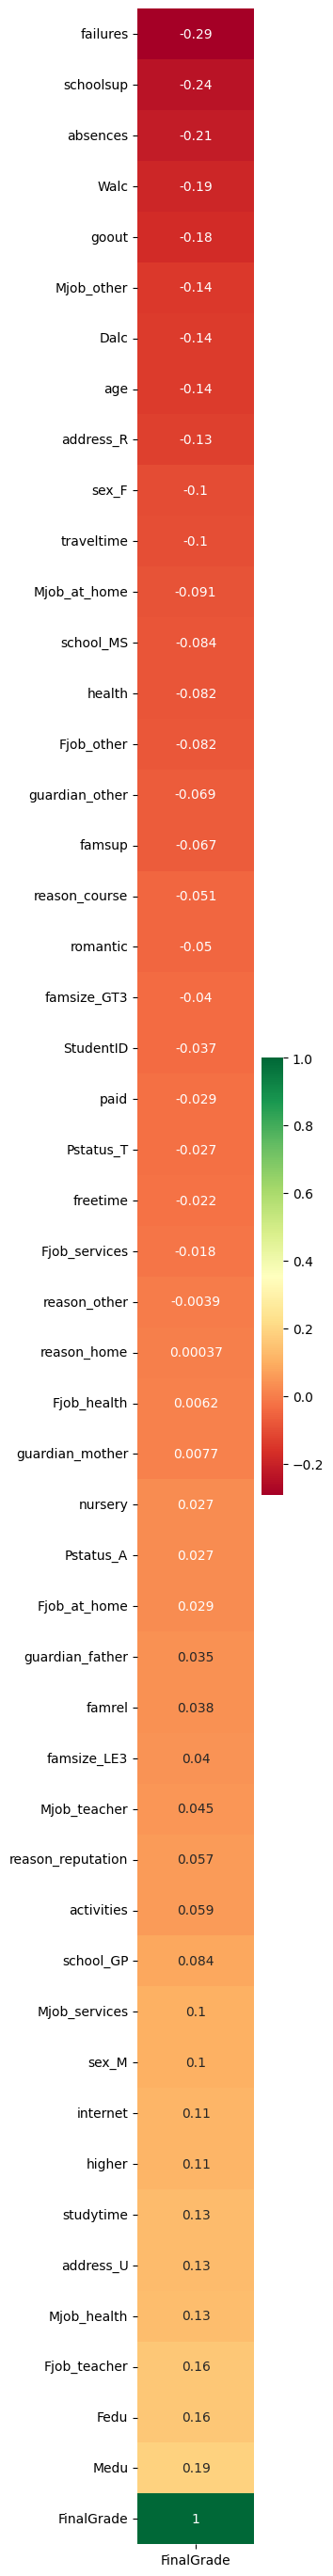

In [21]:
df_copy = df_preprocessed.copy()

X = df_copy.drop(['StudentID', 'FirstName', 'FamilyName', 'FinalGrade'], axis = 1)  #independent columns
y = df_preprocessed[target]    #target column i.e price range
#get correlations of each features in dataset
corrmat = df_preprocessed.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(2,35))
#plot heat map
g=sns.heatmap(df_preprocessed[top_corr_features].corr().loc[target].transpose().sort_values(by = 'FinalGrade', ascending = True),annot=True,cmap="RdYlGn")

In [22]:
np.abs(df_preprocessed[top_corr_features].corr().loc[target].transpose()).sort_values(by = 'FinalGrade', ascending = False).transpose()

,FinalGrade,failures,schoolsup,absences,Medu,Walc,goout,Fedu,Fjob_teacher,Mjob_other,Dalc,age,Mjob_health,address_R,address_U,studytime,higher,internet,sex_M,sex_F,Mjob_services,traveltime,Mjob_at_home,school_GP,school_MS,health,Fjob_other,guardian_other,famsup,activities,reason_reputation,reason_course,romantic,Mjob_teacher,famsize_GT3,famsize_LE3,famrel,StudentID,guardian_father,Fjob_at_home,paid,Pstatus_T,Pstatus_A,nursery,freetime,Fjob_services,guardian_mother,Fjob_health,reason_other,reason_home
FinalGrade,1.0,0.293831,0.238365,0.213129,0.190308,0.190054,0.177383,0.158811,0.158455,0.142541,0.14069,0.140372,0.134581,0.13009,0.13009,0.126728,0.113419,0.111624,0.102448,0.102448,0.102134,0.099785,0.090624,0.083615,0.083615,0.081691,0.081502,0.069491,0.067305,0.0586,0.056573,0.050918,0.049944,0.04539,0.039744,0.039744,0.037711,0.03666,0.03522,0.028954,0.028899,0.026665,0.026665,0.026541,0.021589,0.018154,0.007728,0.006241,0.003897,0.000372


In [23]:
features_test1 = ['failures', 'schoolsup', 'absences', 'Medu', 'Walc', 'goout', 'Mjob_other', 'Dalc', 'age', 'Mjob_health', 'address_R', 'address_U', 'studytime', 'higher', 'internet', 'sex_M', 'sex_F', 'Mjob_services']
features_test2 = ['failures', 'schoolsup', 'absences', 'Medu', 'Walc', 'goout', 'Mjob_other', 'Dalc', 'age', 'Mjob_health']
features_test3 = ['failures', 'schoolsup', 'absences', 'Walc', 'goout', 'Dalc', 'studytime', 'internet']

### Model

In [24]:
X = df_preprocessed[features_test3]
y = df_preprocessed[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

2.7916926375343976

In [26]:
lr = Lasso(0.08)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

2.7718319283189223

In [27]:
lr = Ridge(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

2.791670992308728

In [40]:
from sklearn.model_selection import GridSearchCV

def search_best_params_xgbregressor(X_train, y_train, X_test, y_test):

    params = { 'max_depth': [3,6,10],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 500, 1000],
            'colsample_bytree': [0.3, 0.7]}

    fit_params = {"eval_set" : [[X_test, y_test]]}

    xgbr = xgb.XGBRegressor(seed = 20)
    clf = GridSearchCV(estimator=xgbr, 
                    param_grid=params,
                    scoring='neg_mean_squared_error', 
                    verbose=0)
                    
    clf.fit(X_train, y_train, **fit_params, verbose=0)

    best_params = clf.best_params_
    rmse = (-clf.best_score_)**(1/2.0)

    print("Best parameters:", best_params)
    print("Lowest RMSE: ", rmse)

    return best_params, rmse


In [ ]:
y_test_pred = y_test.copy()
y_test_pred['FinalGrade_pred'] = y_pred

In [ ]:
y_test_pred

In [ ]:
sns.scatterplot(data=y_test_pred, x="FinalGrade", y="FinalGrade_pred")

In [ ]:
y_tot_pred = lr.predict(X)

In [ ]:
y_tot = y.copy()
y_tot['pred'] = y_tot_pred

In [ ]:
df_tot = y_tot.merge(df_student[['FirstName', 'FamilyName']], left_index = True, right_index = True)
df_tot['Full_Name'] = df_tot['FirstName'] + ' ' + df_tot['FamilyName']

In [ ]:
df_tot

In [ ]:
sns.scatterplot(data=y_tot, x="FinalGrade", y="pred")

In [ ]:
fig = px.scatter(df_tot, x="FinalGrade", y="pred", hover_name = "Full_Name", 
)
fig.update_traces(textposition='top center', marker= dict(color = 'red'))
fig.update_layout(
    height=800,
    title_text='Score in function of FinalGrade',
)


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

for model_class in (LinearRegression, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    mlmodel = model_class()
    mlmodel.fit(X_train, y_train)

    y_pred = mlmodel.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(model_class)
    print(rmse)
    



In [37]:
def best_param_lasso_ridge(model, X_train, y_train, X_test, y_test):

    # function that determines best param for lasso and ridge model
    
    liste_alphas_rmse = []

    for alpha in np.arange(0.01, 3, 0.01):
        lr = model(alpha)
        lr.fit(X_train, y_train)

        y_pred = lr.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        liste_alphas_rmse.append((alpha, rmse))

    liste_alphas_rmse.sort(key=lambda y: y[1])
    
    alpha_optimal = liste_alphas_rmse[0][0]
    rmse = liste_alphas_rmse[0][1]

    return alpha_optimal, rmse


In [41]:
def search_best_model(model_list_str):
    # search
    model_list_str = ['LinearRegression', 'Lasso', 'Ridge', 'XGBRegressor']

    liste_model_rmse = []

    for model in model_list_str:

        if model == 'LinearRegression':

            lr = LinearRegression()
            lr.fit(X_train, y_train)

            y_pred = lr.predict(X_test)

            rmse = mean_squared_error(y_test, y_pred, squared=False)
            liste_model_rmse.append((lr, rmse))

        elif model == 'Lasso':
            alpha_optimal, rmse = best_param_lasso_ridge(Lasso, X_train, y_train, X_test, y_test)
            lr = Lasso(alpha_optimal)
            liste_model_rmse.append((lr, rmse))

        elif model == 'Ridge':
            alpha_optimal, rmse = best_param_lasso_ridge(Ridge, X_train, y_train, X_test, y_test)
            lr = Ridge(alpha_optimal)
            liste_model_rmse.append((lr, rmse))

        elif model == 'XGBRegressor':
            best_params, rmse = search_best_params_xgbregressor(X_train, y_train, X_test, y_test)
            lr = XGBRegressor(max_depth = best_params['max_depth'],
                              learning_rate = best_params['learning_rate'],
                              n_estimators = best_params['n_estimators'],
                              colsample_bytree = best_params['colsample_bytree']
                              )
            liste_model_rmse.append((lr, rmse))

    liste_model_rmse.sort(key=lambda y: y[1])

    print(liste_model_rmse)

    best_model = liste_model_rmse[0][0]
    lowest_rmse = liste_model_rmse[0][1]

    print("best model is :", best_model)
        
search_best_model()

Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Lowest RMSE:  3.0150530362096726
[(Lasso(alpha=0.08), 2.7718319283189223), (Ridge(alpha=2.9899999999999998), 2.7864372492591536), (LinearRegression(), 2.7916926375343976), (XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...

In [ ]:
best_param_lasso_ridge(Lasso)